## 1. DeepFakesON-Phys-style rPPG Baseline (CAN-like 3D CNN)

In this section we implement a DeepFakesON-Phys-inspired rPPG deepfake detector.

**Goal:**  
Use subtle physiological cues (remote PPG / blood volume changes) from facial videos to classify **real vs fake**.

### Pipeline

1. **Preprocessing**
   - Read video frames with OpenCV.
   - Detect face using MTCNN (fall back to center crop if detection fails).
   - From the face bounding box, crop a stable skin region (cheeks/forehead).
   - Sample a fixed-length clip, e.g., `T = 128` frames.
   - Resize crops to a fixed size, e.g., `H = W = 112`.

2. **rPPG representation**
   - Convert each frame to RGB and normalize to `[0, 1]`.
   - Stack frames into a spatio-temporal tensor of shape `[T, H, W, 3]`.
   - Permute to `[C, T, H, W]` for 3D convolutions.

3. **Network (CAN-like 3D CNN)**
   - Several 3D convolutional blocks (C3D-style) to capture spatial + temporal patterns.
   - A simple spatial attention mechanism to emphasize skin regions.
   - Global temporal pooling → feature vector.
   - MLP classifier → binary label (real / fake).

4. **Training**
   - Binary classification with `BCEWithLogitsLoss`.
   - Metrics: loss, accuracy (optionally AUC later).

5. **Visualization (for the report)**
   - Show example preprocessed clip (cropped face region over time).
   - Plot a simple rPPG-like signal: mean green intensity over time for that clip.

### Cell 2: Imports, config, and seeding

In [1]:
import os
import random
import math
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from sklearn.metrics import roc_auc_score

# Optional: facenet-pytorch for MTCNN face detection
try:
    from facenet_pytorch import MTCNN
    FACENET_AVAILABLE = True
except ImportError:
    FACENET_AVAILABLE = False
    print("facenet-pytorch not installed. We'll fall back to simple center crop.")

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_ROOT = Path("/kaggle/input/celeb-df-v2")
METADATA_CSV = Path("metadata_celebdf_v2.csv")

# rPPG / clip config
CLIP_LEN = 64        # number of frames per clip
FRAME_SIZE = 96      # crop size
FPS_TARGET = 25       # for sampling; we will sample uniformly by frame index

# Training config
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 1e-4
NUM_EPOCHS = 5


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

set_seed(42)

print("Device:", DEVICE)

facenet-pytorch not installed. We'll fall back to simple center crop.
Device: cuda


## 1.A Celeb-DF (v2) Metadata Builder + Official Test Split

Celeb-DF (v2) is organized into three main folders:

- `Celeb-real` – real face videos (originals)
- `YouTube-real` – additional real videos
- `Celeb-synthesis` – DeepFake synthesized videos

There is also a text file:
- `List_of_testing_videos.txt` – list of videos assigned to the official **test set** in the original paper.

In this feature we:

1. Scan these folders to build a `metadata_celebdf_v2.csv` file with:
   - `video_path`: path to each video **relative to the dataset root**
   - `label`: `0` for real, `1` for fake
   - `split`: `train` or `test` (based on the official test list)

2. Update our `CelebDFRPPGDataset` to:
   - Respect the `split` column when creating `train`, `val`, and `test` sets
   - Use only non-test videos for `train` and `val`, splitting them with a configurable `val_ratio`

3. Visualize the resulting distribution of videos by split and label to include in the paper/report.

### CELL A1: Build metadata_celebdf_v2.csv from folder structure + test list

In [2]:
from pathlib import Path
import os
import pandas as pd

DATA_ROOT = Path("/kaggle/input/celeb-df-v2")

test_list_path = DATA_ROOT / "List_of_testing_videos.txt"
if not test_list_path.exists():
    raise FileNotFoundError(f"Cannot find List_of_testing_videos.txt at {test_list_path}")

test_paths = []

with open(test_list_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()

        # Format: "<label_flag> <relative_path>"
        # label_flag: "0" = real, "1" = fake
        if len(parts) >= 2 and parts[0] in {"0", "1"}:
            # label_flag = int(parts[0])  # we could use this, but folder already encodes it
            rel_path = parts[1]
        else:
            # Fallback: last token is path
            rel_path = parts[-1]

        test_paths.append(rel_path)

test_set = set(test_paths)
print(f"Loaded {len(test_set)} test entries (all lines) from {test_list_path.name}")

rows = []

label_map = {
    "Celeb-real": 0,        # real
    "YouTube-real": 0,      # real
    "Celeb-synthesis": 1    # fake
}

video_dirs = ["Celeb-real", "YouTube-real", "Celeb-synthesis"]

for vd in video_dirs:
    folder = DATA_ROOT / vd
    if not folder.exists():
        print(f"[WARN] Folder not found: {folder}")
        continue

    video_files = []
    for ext in ("*.mp4", "*.avi", "*.mov", "*.mkv"):
        video_files.extend(folder.rglob(ext))

    print(f"Scanning {folder.name}: found {len(video_files)} video files.")

    for vf in video_files:
        # Path relative to DATA_ROOT, to match the txt file entries
        rel_path = vf.relative_to(DATA_ROOT).as_posix()
        label = label_map.get(vf.parent.name, None)
        if label is None:
            continue

        split = "test" if rel_path in test_set else "train"

        rows.append({
            "video_path": rel_path,
            "label": label,   
            "split": split
        })

metadata_df = pd.DataFrame(rows)
print("Total videos collected:", len(metadata_df))

METADATA_CSV = Path("metadata_celebdf_v2.csv")
metadata_df.to_csv(METADATA_CSV, index=False)

print(f"Saved metadata to {METADATA_CSV.resolve()}")
display(metadata_df.head())
print(metadata_df["split"].value_counts())
print(metadata_df.groupby(["split", "label"]).size())

Loaded 518 test entries (all lines) from List_of_testing_videos.txt
Scanning Celeb-real: found 590 video files.
Scanning YouTube-real: found 300 video files.
Scanning Celeb-synthesis: found 5639 video files.
Total videos collected: 6529
Saved metadata to /kaggle/working/metadata_celebdf_v2.csv


,video_path,label,split
0,Celeb-real/id49_0006.mp4,0,train
1,Celeb-real/id27_0008.mp4,0,test
2,Celeb-real/id32_0000.mp4,0,train
3,Celeb-real/id1_0006.mp4,0,test
4,Celeb-real/id50_0006.mp4,0,test


split
train    6011
test      518
Name: count, dtype: int64
split  label
test   0         178
       1         340
train  0         712
       1        5299
dtype: int64


### CELL A2: CelebDFRPPGDataset using metadata split (train/val/test)

In [3]:
class CelebDFRPPGDataset(Dataset):
    def __init__(self,
                 metadata_csv,
                 clip_len=CLIP_LEN,
                 frame_size=FRAME_SIZE,
                 split="train",
                 val_ratio=0.2,
                 random_start=True,
                 augment=False):
        """Perform a deterministic random split into train/val using val_ratio"""
        self.df = pd.read_csv(metadata_csv)

        if "split" not in self.df.columns:
            raise ValueError("metadata_csv must contain a 'split' column (train/test).")

        self.clip_len = clip_len
        self.frame_size = frame_size
        self.random_start = random_start
        self.augment = augment

        if split == "test":
            base_df = self.df[self.df["split"] == "test"].reset_index(drop=True)
            self.indices = np.arange(len(base_df))
            self.base_df = base_df
            print(f"test set: {len(self.indices)} videos")
        else:
            # Use all non-test videos for train/val split
            base_df = self.df[self.df["split"] != "test"].reset_index(drop=True)
            num_samples = len(base_df)
            indices = np.arange(num_samples)
            np.random.seed(42)
            np.random.shuffle(indices)

            val_size = int(num_samples * val_ratio)
            val_indices = indices[:val_size]
            train_indices = indices[val_size:]

            if split == "train":
                self.indices = train_indices
            elif split == "val":
                self.indices = val_indices
            else:
                raise ValueError("split must be 'train', 'val', or 'test'")

            self.base_df = base_df
            print(f"{split} set: {len(self.indices)} videos (val_ratio={val_ratio})")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        row = self.base_df.iloc[real_idx]
        video_path = row["video_path"]
        label = int(row["label"])

        full_path = DATA_ROOT / video_path  # metadata is relative to DATA_ROOT

        # Use try-except to handle problematic videos
        try:
            max_frames = CLIP_LEN * 2
            frames = read_video_frames(str(full_path), max_frames=max_frames, timeout=READ_VIDEO_TIMEOUT)
            
            if len(frames) == 0:
                print(f"[INFO] No frames read for {full_path}, using dummy clip")
                clip = torch.zeros(3, self.clip_len, self.frame_size, self.frame_size,
                                   dtype=torch.float32)
            else:
                try:
                    clip = preprocess_clip(frames,
                                           clip_len=self.clip_len,
                                           frame_size=self.frame_size,
                                           random_start=self.random_start,
                                           augment=self.augment)
                except Exception as e:
                    print(f"[WARN] Error preprocessing {full_path}: {e}, using dummy clip")
                    clip = torch.zeros(3, self.clip_len, self.frame_size, self.frame_size,
                                       dtype=torch.float32)
        except Exception as e:
            print(f"[WARN] Error loading {full_path}: {e}, using dummy clip")
            clip = torch.zeros(3, self.clip_len, self.frame_size, self.frame_size,
                               dtype=torch.float32)

        y = torch.tensor(label, dtype=torch.float32)
        return clip, y


# Recreate datasets & loaders using the new metadata and dataset class
train_dataset = CelebDFRPPGDataset(METADATA_CSV, split="train", val_ratio=0.2, random_start=True, augment=True)
val_dataset   = CelebDFRPPGDataset(METADATA_CSV, split="val",   val_ratio=0.2, random_start=False, augment=False)
test_dataset  = CelebDFRPPGDataset(METADATA_CSV, split="test",  val_ratio=0.2, random_start=False, augment=False)

# IMPORTANT: Use num_workers=0 so signal-based timeout works (runs in main thread)
# This is required for the timeout to properly interrupt blocking cv2.read() calls
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)

print("Train batches:", len(train_loader),
      "| Val batches:", len(val_loader),
      "| Test batches:", len(test_loader))

train set: 4809 videos (val_ratio=0.2)
val set: 1202 videos (val_ratio=0.2)
test set: 518 videos
Train batches: 1203 | Val batches: 301 | Test batches: 130


### CELL A3: Visualization – distribution of videos per split & label

   split  label  count
0   test      0    178
1   test      1    340
2  train      0    712
3  train      1   5299


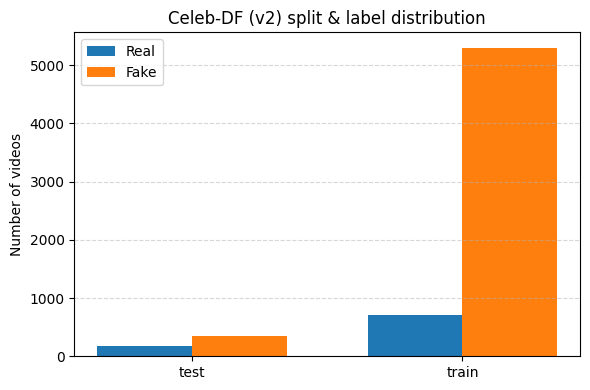

In [5]:
import matplotlib.pyplot as plt

md = pd.read_csv(METADATA_CSV)

counts = md.groupby(["split", "label"]).size().reset_index(name="count")
print(counts)

label_names = {0: "Real", 1: "Fake"}
counts["label_name"] = counts["label"].map(label_names)

splits = counts["split"].unique()
labels = counts["label_name"].unique()

# Simple grouped bar plot
fig, ax = plt.subplots(figsize=(6, 4))

x = np.arange(len(splits))
width = 0.35

for i, lbl in enumerate(labels):
    sub = counts[counts["label_name"] == lbl]
    y = [sub[sub["split"] == s]["count"].values[0] if s in sub["split"].values else 0 for s in splits]
    ax.bar(x + (i - 0.5) * width, y, width, label=lbl)

ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.set_ylabel("Number of videos")
ax.set_title("Celeb-DF (v2) split & label distribution")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Cell 4: Video reading & clip sampling utilities

In [4]:
import time
import signal
import multiprocessing as mp

# Hard cap to prevent hangs on broken files
READ_VIDEO_TIMEOUT = 10


class VideoReadTimeout(Exception):
    """Exception raised when video reading times out."""
    pass


def _timeout_handler(signum, frame):
    """Signal handler for timeout."""
    raise VideoReadTimeout("Video read timed out")


def _read_video_worker(path, max_frames, result_queue):
    """Worker function for multiprocessing-based video reading."""
    frames = []
    try:
        cap = cv2.VideoCapture(str(path))
        if not cap.isOpened():
            result_queue.put(("error", "open_fail"))
            return

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
        max_frames_local = min(max_frames, frame_count) if frame_count > 0 else max_frames

        count = 0
        consecutive_failures = 0

        while count < max_frames_local:
            ret, frame = cap.read()
            if not ret:
                consecutive_failures += 1
                if consecutive_failures >= 3:
                    break
                continue
            consecutive_failures = 0
            frames.append(frame)
            count += 1

        cap.release()
        result_queue.put(("success", frames))
    except Exception as e:
        result_queue.put(("error", str(e)))


def read_video_frames(path: str, max_frames: int = None, timeout: float = READ_VIDEO_TIMEOUT):
    """
    Read frames from a video using OpenCV with a hard timeout.
    Uses signal-based timeout on Linux (Kaggle) or multiprocessing fallback.
    Returns [] if slow or failing.
    """
    if max_frames is None:
        max_frames = CLIP_LEN * 2

    # Try signal-based timeout first (works on Linux/Kaggle in main thread)
    try:
        # Check if we're in the main thread (signal only works there)
        import threading
        if threading.current_thread() is threading.main_thread():
            return _read_video_with_signal_timeout(path, max_frames, timeout)
    except:
        pass

    # Fallback: use multiprocessing with timeout
    return _read_video_with_mp_timeout(path, max_frames, timeout)


def _read_video_with_signal_timeout(path, max_frames, timeout):
    """Read video with signal-based timeout (Linux only, main thread only)."""
    frames = []
    cap = None
    
    # Set up timeout signal
    old_handler = signal.signal(signal.SIGALRM, _timeout_handler)
    signal.alarm(int(timeout))
    
    try:
        cap = cv2.VideoCapture(str(path))
        if not cap.isOpened():
            print(f"[WARN] Cannot open video: {path}")
            return []

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
        max_frames_local = min(max_frames, frame_count) if frame_count > 0 else max_frames

        count = 0
        consecutive_failures = 0

        while count < max_frames_local:
            ret, frame = cap.read()
            if not ret:
                consecutive_failures += 1
                if consecutive_failures >= 3:
                    break
                continue
            consecutive_failures = 0
            frames.append(frame)
            count += 1

    except VideoReadTimeout:
        print(f"[WARN] Timeout reading video (>{timeout}s): {path}")
        frames = []
    except Exception as e:
        print(f"[WARN] Exception reading {path}: {e}")
        frames = []
    finally:
        signal.alarm(0)  # Cancel the alarm
        signal.signal(signal.SIGALRM, old_handler)  # Restore old handler
        if cap is not None:
            try:
                cap.release()
            except:
                pass

    return frames


def _read_video_with_mp_timeout(path, max_frames, timeout):
    """Read video using multiprocessing with timeout (works in worker processes)."""
    ctx = mp.get_context('spawn')
    result_queue = ctx.Queue()
    
    proc = ctx.Process(target=_read_video_worker, args=(path, max_frames, result_queue))
    proc.start()
    proc.join(timeout)
    
    if proc.is_alive():
        print(f"[WARN] Timeout reading video (>{timeout}s): {path}")
        proc.terminate()
        proc.join(1)
        if proc.is_alive():
            proc.kill()
        return []
    
    try:
        if not result_queue.empty():
            status, data = result_queue.get_nowait()
            if status == "success":
                return data
            else:
                print(f"[WARN] Error reading {path}: {data}")
                return []
    except:
        pass
    
    return []


def sample_frame_indices(num_frames: int, clip_len: int, random_start: bool = True):
    """
    Sample `clip_len` indices from a video of length `num_frames`.
    If video is shorter than clip_len, we loop / pad by repeating frames.
    """
    if num_frames <= 0:
        return []

    if num_frames >= clip_len:
        if random_start:
            start = random.randint(0, max(0, num_frames - clip_len))
        else:
            start = max(0, (num_frames - clip_len) // 2)
        indices = list(range(start, start + clip_len))
    else:
        # Repeat frames to reach clip_len
        reps = math.ceil(clip_len / num_frames)
        indices = (list(range(num_frames)) * reps)[:clip_len]

    return indices

### Cell 5: rPPG crop and spatio-temporal tensor creation

In [5]:
def crop_skin_region(frame: np.ndarray, bbox, region_type: str = "mid"):
    """
    Crop a stable face region (e.g., cheeks/forehead) from BGR frame using bbox.

    region_type:
        - "mid": middle band of the face (cheeks)
        - "full": full face bbox
    """
    h, w, _ = frame.shape
    x1, y1, x2, y2 = bbox
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(w - 1, x2); y2 = min(h - 1, y2)

    if region_type == "mid":
        # Take a band around the middle of the face vertically
        face_h = y2 - y1
        y_mid1 = y1 + int(face_h * 0.15)
        y_mid2 = y1 + int(face_h * 0.90)
        y_mid1 = max(y1, y_mid1)
        y_mid2 = min(y2, y_mid2)
        crop = frame[y_mid1:y_mid2, x1:x2]
    else:
        crop = frame[y1:y2, x1:x2]

    if crop.size == 0:
        # Fallback to center crop of the original frame
        fh = fw = min(h, w)
        x1c = (w - fw) // 2
        y1c = (h - fh) // 2
        crop = frame[y1c:y1c+fh, x1c:x1c+fw]
    return crop


def preprocess_clip(frames, clip_len=CLIP_LEN, frame_size=FRAME_SIZE,
                    random_start=True, return_debug=False):
    """
    Returns tensor of shape [C, T, H, W] (float32, normalized to [0,1]).
    If return_debug=True, also returns list of preprocessed RGB frames (H, W, 3) for visualization.
    """
    num_frames = len(frames)
    if num_frames == 0:
        raise ValueError("No frames in video")

    indices = sample_frame_indices(num_frames, clip_len, random_start=random_start)

    crops_rgb = []
    last_bbox = None

    for idx in indices:
        frame = frames[idx]

        # Detect face (use last bbox if current fails)
        bbox = face_detector.detect(frame)
        if bbox is None:
            bbox = last_bbox
        if bbox is None:
            # Last resort: full frame (or center crop is inside detector)
            h, w, _ = frame.shape
            size = int(min(h, w) * 0.6)
            cx, cy = w // 2, h // 2
            x1 = max(0, cx - size // 2)
            y1 = max(0, cy - size // 2)
            x2 = min(w - 1, x1 + size)
            y2 = min(h - 1, y1 + size)
            bbox = (x1, y1, x2, y2)

        last_bbox = bbox

        # Crop cheeks/mid-band
        crop_bgr = crop_skin_region(frame, bbox, region_type="mid")
        crop_bgr = cv2.resize(crop_bgr, (frame_size, frame_size), interpolation=cv2.INTER_LINEAR)
        crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)

        crops_rgb.append(crop_rgb)

    # Stack to [T, H, W, 3]
    clip_arr = np.stack(crops_rgb, axis=0).astype(np.float32) / 255.0
    # To [C, T, H, W]
    clip_arr = np.transpose(clip_arr, (3, 0, 1, 2))  # (3, T, H, W)
    clip_tensor = torch.from_numpy(clip_arr)  # float32

    if return_debug:
        return clip_tensor, crops_rgb
    return clip_tensor

## Enable OpenCV Haar Face Detection

- Use **OpenCV's Haar cascade** (`haarcascade_frontalface_default.xml`) to detect faces.
- For each frame, we detect faces in grayscale, pick the largest one, and
  derive a bounding box.

### CELL H2: OpenCV Haar-based FaceDetector

In [6]:
import cv2

class HaarFaceDetector:
    def __init__(self):
        # Use OpenCV's built-in frontal face cascade
        cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        self.detector = cv2.CascadeClassifier(cascade_path)
        if self.detector.empty():
            raise RuntimeError(f"Failed to load Haar cascade from {cascade_path}")

    def detect(self, frame):
        """
        Detect face bounding box in a single BGR frame using OpenCV Haar cascades.
        Returns (x1, y1, x2, y2) or None if detection fails.
        """
        h, w, _ = frame.shape

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # DetectMultiScale returns [x, y, w, h] for each face
        faces = self.detector.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(60, 60)
        )

        if len(faces) == 0:
            # Fallback: center crop (same logic as before)
            size = int(min(h, w) * 0.6)
            cx, cy = w // 2, h // 2
            x1 = max(0, cx - size // 2)
            y1 = max(0, cy - size // 2)
            x2 = min(w - 1, x1 + size)
            y2 = min(h - 1, y1 + size)
            return (x1, y1, x2, y2)

        # Choose the largest detected face (by area)
        faces = sorted(faces, key=lambda f: f[2] * f[3], reverse=True)
        x, y, fw, fh = faces[0]
        x1 = max(0, x)
        y1 = max(0, y)
        x2 = min(w - 1, x + fw)
        y2 = min(h - 1, y + fh)
        return (x1, y1, x2, y2)


# Override the global face_detector used by preprocess_clip
face_detector = HaarFaceDetector()
print("Using OpenCV HaarFaceDetector for face detection.")

Using OpenCV HaarFaceDetector for face detection.


### CELL H3: Visualization – Haar face bbox vs simple center crop

Sample video: Celeb-real/id23_0009.mp4 | Label (0=real,1=fake): 0


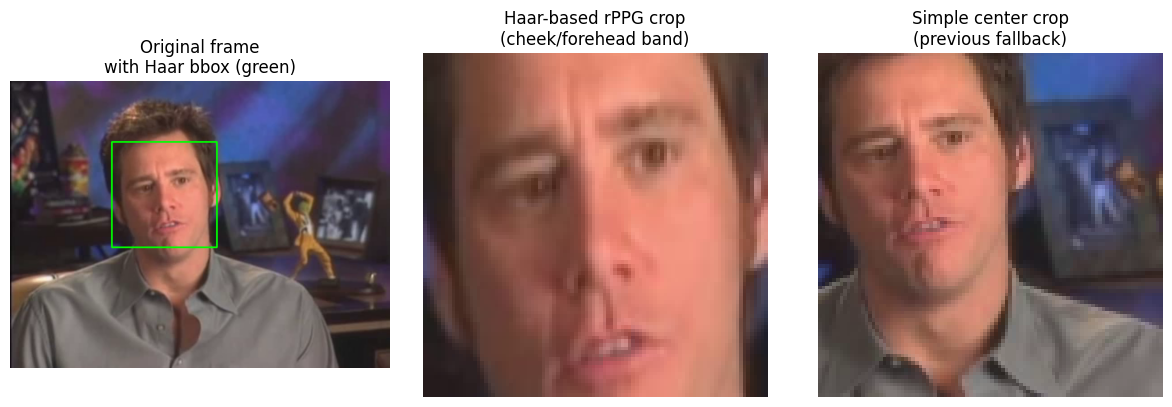

In [15]:
import random
import matplotlib.pyplot as plt

# Reload metadata and pick a sample video
md = pd.read_csv(METADATA_CSV)

# Pick a random train video for visualization
sample_row = md[md["split"] == "train"].sample(1, random_state=42).iloc[0]
sample_path = sample_row["video_path"]
full_path = DATA_ROOT / sample_path

print("Sample video:", sample_path, "| Label (0=real,1=fake):", sample_row["label"])

max_frames = CLIP_LEN * 2
frames = read_video_frames(str(full_path), max_frames=max_frames)
if len(frames) == 0:
    raise RuntimeError(f"Could not read any frames from {full_path}")

# Use a middle frame
mid_idx = len(frames) // 2
frame_bgr = frames[mid_idx].copy()
h, w, _ = frame_bgr.shape

# Haar-based bbox & rPPG crop
bbox_haar = face_detector.detect(frame_bgr)
x1_h, y1_h, x2_h, y2_h = bbox_haar

haar_crop_bgr = crop_skin_region(frame_bgr, bbox_haar, region_type="mid")
haar_crop_bgr = cv2.resize(haar_crop_bgr, (FRAME_SIZE, FRAME_SIZE))
haar_crop_rgb = cv2.cvtColor(haar_crop_bgr, cv2.COLOR_BGR2RGB)

frame_haar_box = frame_bgr.copy()
cv2.rectangle(frame_haar_box, (x1_h, y1_h), (x2_h, y2_h), (0, 255, 0), 2)
frame_haar_box_rgb = cv2.cvtColor(frame_haar_box, cv2.COLOR_BGR2RGB)

# Simple center crop
size_c = int(min(h, w) * 0.6)
cx, cy = w // 2, h // 2
x1_c = max(0, cx - size_c // 2)
y1_c = max(0, cy - size_c // 2)
x2_c = min(w - 1, x1_c + size_c)
y2_c = min(h - 1, y1_c + size_c)

center_crop_bgr = frame_bgr[y1_c:y2_c, x1_c:x2_c]
center_crop_bgr = cv2.resize(center_crop_bgr, (FRAME_SIZE, FRAME_SIZE))
center_crop_rgb = cv2.cvtColor(center_crop_bgr, cv2.COLOR_BGR2RGB)

frame_center_box = frame_bgr.copy()
cv2.rectangle(frame_center_box, (x1_c, y1_c), (x2_c, y2_c), (255, 0, 0), 2)
frame_center_box_rgb = cv2.cvtColor(frame_center_box, cv2.COLOR_BGR2RGB)

# Plot: original + Haar bbox, Haar rPPG crop, center crop

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(frame_haar_box_rgb)
axes[0].set_title("Original frame\nwith Haar bbox (green)")
axes[0].axis("off")

axes[1].imshow(haar_crop_rgb)
axes[1].set_title("Haar-based rPPG crop\n(cheek/forehead band)")
axes[1].axis("off")

axes[2].imshow(center_crop_rgb)
axes[2].set_title("Simple center crop\n(previous fallback)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

## Reuse Face Bounding Box Across Frames

In the original `preprocess_clip`, we ran face detection **for every sampled frame**
in a clip. This is very expensive on the CPU (OpenCV Haar detection), and the GPU
often sits idle waiting for preprocessing to finish.

However, in most short clips the **face does not move much from frame to frame**,
so we can safely:

- Run face detection only **once every *k* frames** (e.g., every 8 frames).
- Reuse the last detected bounding box for the frames in between.

This reduces the number of Haar detections by roughly a factor of `k`, while
usually introducing only a small localization error that the network can handle.

We:

1. Redefine `preprocess_clip` to accept a `detect_every` parameter and reuse the
   last bounding box for intermediate frames.
2. Keep the same output format: tensor `[C, T, H, W]` with optional debug frames.
3. Add a visualization that compares:
   - Per-frame detection (detect every frame)
   - Reuse-based detection (detect every `k` frames)
   to show they are very similar in practice.

### CELL R2: Redefine preprocess_clip to reuse bbox every `detect_every` frames

In [7]:
DETECT_EVERY = 8  # detect face every N frames, reuse bbox in between

def preprocess_clip(frames,
                    clip_len=CLIP_LEN,
                    frame_size=FRAME_SIZE,
                    random_start=True,
                    detect_every=DETECT_EVERY,
                    augment=False,
                    return_debug=False):
    """
    Returns tensor of shape [C, T, H, W] (float32, normalized to [0,1]).

    Optimization:
      - Run face detection only once every `detect_every` frames.
      - Reuse the last bounding box for intermediate frames.
    
    Augmentation (if augment=True):
      - Random horizontal flip (consistent across all frames in clip)
    """
    num_frames = len(frames)
    if num_frames == 0:
        raise ValueError("No frames in video")

    indices = sample_frame_indices(num_frames, clip_len, random_start=random_start)
    
    # Augmentation decision
    do_hflip = augment and (random.random() > 0.5)

    crops_rgb = []
    last_bbox = None

    for t, idx in enumerate(indices):
        frame = frames[idx]
        
        # Apply horizontal flip if augmenting
        if do_hflip:
            frame = cv2.flip(frame, 1)

        # Decide whether to run detection or reuse last bbox
        if (t % detect_every == 0) or (last_bbox is None):
            bbox = face_detector.detect(frame)
            if bbox is None:
                bbox = last_bbox
        else:
            bbox = last_bbox

        if bbox is None:
            # Still no bbox -> fallback center crop
            h, w, _ = frame.shape
            size = int(min(h, w) * 0.6)
            cx, cy = w // 2, h // 2
            x1 = max(0, cx - size // 2)
            y1 = max(0, cy - size // 2)
            x2 = min(w - 1, x1 + size)
            y2 = min(h - 1, y1 + size)
            bbox = (x1, y1, x2, y2)

        last_bbox = bbox

        # Crop cheeks/mid-band using the chosen bbox
        crop_bgr = crop_skin_region(frame, bbox, region_type="mid")
        crop_bgr = cv2.resize(crop_bgr, (frame_size, frame_size), interpolation=cv2.INTER_LINEAR)
        crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)

        crops_rgb.append(crop_rgb)

    # Stack to [T, H, W, 3]
    clip_arr = np.stack(crops_rgb, axis=0).astype(np.float32) / 255.0
    # To [C, T, H, W]
    clip_arr = np.transpose(clip_arr, (3, 0, 1, 2))  # (3, T, H, W)
    clip_tensor = torch.from_numpy(clip_arr)

    if return_debug:
        return clip_tensor, crops_rgb
    return clip_tensor

print(f"preprocess_clip redefined with bbox reuse every {DETECT_EVERY} frames.")

preprocess_clip redefined with bbox reuse every 8 frames.


### CELL R3: Visualization – per-frame detection vs bbox reuse

Sample video for bbox reuse visualization: Celeb-synthesis/id37_id33_0002.mp4


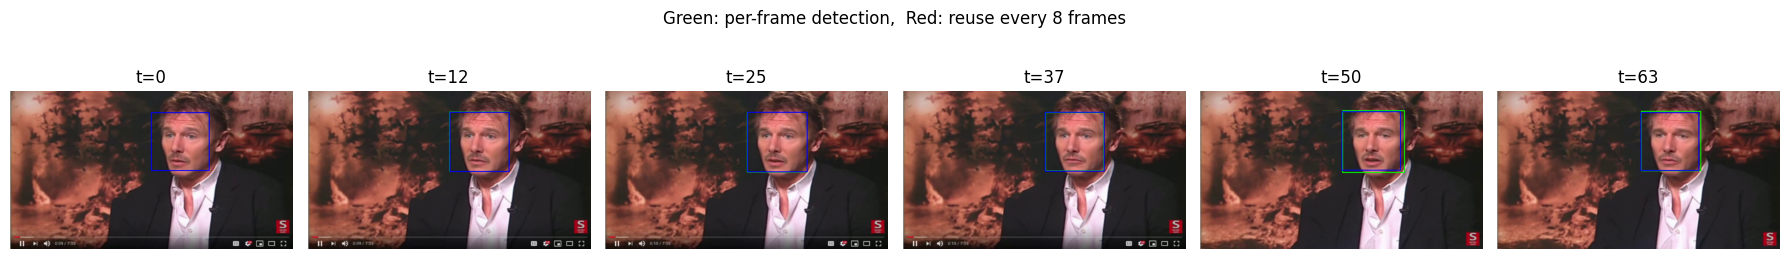

In [17]:
import matplotlib.pyplot as plt

# Take a sample train video
md = pd.read_csv(METADATA_CSV)
sample_row = md[md["split"] == "train"].sample(1, random_state=55).iloc[0]
sample_path = sample_row["video_path"]
full_path = DATA_ROOT / sample_path

print("Sample video for bbox reuse visualization:", sample_path)

max_frames = CLIP_LEN * 2
frames = read_video_frames(str(full_path), max_frames=max_frames)
if len(frames) == 0:
    raise RuntimeError(f"Could not read any frames from {full_path}")

# Use the same indices as preprocess_clip would
indices = sample_frame_indices(len(frames), clip_len=min(CLIP_LEN, len(frames)), random_start=False)

# Per-frame detection (baseline)
bboxes_full = []
for idx in indices:
    frame = frames[idx]
    bbox = face_detector.detect(frame)
    if bbox is None:
        # fallback center crop
        h, w, _ = frame.shape
        size = int(min(h, w) * 0.6)
        cx, cy = w // 2, h // 2
        x1 = max(0, cx - size // 2)
        y1 = max(0, cy - size // 2)
        x2 = min(w - 1, x1 + size)
        y2 = min(h - 1, y1 + size)
        bbox = (x1, y1, x2, y2)
    bboxes_full.append(bbox)

# Reuse-based detection
bboxes_reuse = []
last_bbox = None
for t, idx in enumerate(indices):
    frame = frames[idx]
    if (t % DETECT_EVERY == 0) or (last_bbox is None):
        bbox = face_detector.detect(frame)
        if bbox is None:
            bbox = last_bbox
    else:
        bbox = last_bbox

    if bbox is None:
        h, w, _ = frame.shape
        size = int(min(h, w) * 0.6)
        cx, cy = w // 2, h // 2
        x1 = max(0, cx - size // 2)
        y1 = max(0, cy - size // 2)
        x2 = min(w - 1, x1 + size)
        y2 = min(h - 1, y1 + size)
        bbox = (x1, y1, x2, y2)

    last_bbox = bbox
    bboxes_reuse.append(bbox)

# Show a few frames with both boxes overlayed

num_show = 6
idxs_show = np.linspace(0, len(indices) - 1, num_show, dtype=int)

fig, axes = plt.subplots(1, num_show, figsize=(3 * num_show, 3))

for i, t in enumerate(idxs_show):
    idx = indices[t]
    frame_bgr = frames[idx].copy()
    h, w, _ = frame_bgr.shape

    # Per-frame (green)
    x1f, y1f, x2f, y2f = bboxes_full[t]
    cv2.rectangle(frame_bgr, (x1f, y1f), (x2f, y2f), (0, 255, 0), 2)

    # Reuse-based (red)
    x1r, y1r, x2r, y2r = bboxes_reuse[t]
    cv2.rectangle(frame_bgr, (x1r, y1r), (x2r, y2r), (255, 0, 0), 2)

    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    axes[i].imshow(frame_rgb)
    axes[i].axis("off")
    axes[i].set_title(f"t={t}")

plt.suptitle("Green: per-frame detection,  Red: reuse every "
             f"{DETECT_EVERY} frames")
plt.tight_layout()
plt.show()

### Cell 6: 3D CNN model (DeepFakesONPhysBaseline)

In [8]:
class SpatialAttention3D(nn.Module):
    """
    Simple spatial attention:
    - Average pool over channels and time -> [B, 1, 1, H, W]
    - Convolution + sigmoid -> attention map
    """
    def __init__(self, kernel_size=1):
        super().__init__()
        self.conv = nn.Conv3d(1, 1, kernel_size=(1, kernel_size, kernel_size),
                              padding=(0, kernel_size // 2, kernel_size // 2))

    def forward(self, x):
        # x: [B, C, T, H, W]
        # pool over C and T
        att = x.mean(dim=1, keepdim=True)  # [B, 1, T, H, W]
        att = att.mean(dim=2, keepdim=True)  # [B, 1, 1, H, W]
        att = self.conv(att)                # [B, 1, 1, H, W]
        att = torch.sigmoid(att)
        return x * att


class ConvBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, pool=True):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2)) if pool else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x


class DeepFakesOnPhysBaseline(nn.Module):
    """
    Simplified DeepFakesON-Phys style model:
    - 3D CNN blocks + spatial attention.
    - Global temporal pooling + MLP classifier.
    """
    def __init__(self, in_channels=3, base_channels=16):
        super().__init__()

        self.block1 = ConvBlock3D(in_channels, base_channels, kernel_size=3, pool=True)
        self.block2 = ConvBlock3D(base_channels, base_channels * 2, kernel_size=3, pool=True)
        self.block3 = ConvBlock3D(base_channels * 2, base_channels * 4, kernel_size=3, pool=True)

        self.attn = SpatialAttention3D(kernel_size=3)

        # After blocks, we do:
        # 1) Global average over H, W
        # 2) Global average over T
        # So feature dim = base_channels * 4
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(base_channels * 4, 64)
        self.fc2 = nn.Linear(64, 1)  # binary classification (logit)

    def forward(self, x):
        # x: [B, C, T, H, W]
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.attn(x)

        # Global average pooling over spatial dims
        x = x.mean(dim=[3, 4])  # [B, C, T]
        # Global average over time
        x = x.mean(dim=2)       # [B, C]

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(1)  # [B]
        return x


model = DeepFakesOnPhysBaseline(in_channels=3, base_channels=16).to(DEVICE)

# Class imbalance: 712 real vs 5299 fake in training set
# Use pos_weight = n_neg/n_pos where pos=fake, neg=real
POS_WEIGHT = 712 / 5299  # ~0.134 - this upweights real class misses
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([POS_WEIGHT]).to(DEVICE))

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

# Learning rate scheduler for better convergence
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Mixed precision for faster training
use_amp = torch.cuda.is_available() and hasattr(torch.cuda, 'amp')
scaler = torch.amp.GradScaler('cuda') if use_amp else None
print(f"Mixed precision training: {'enabled' if use_amp else 'disabled'}")

print(model)
print(f"\nClass balance: pos_weight={POS_WEIGHT:.4f} (upweights real class)")

Mixed precision training: enabled
DeepFakesOnPhysBaseline(
  (block1): ConvBlock3D(
    (conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ConvBlock3D(
    (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): ConvBlock3D(
    (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace

### Cell 7: Training & validation loop

In [22]:
from pathlib import Path
import torch


GRAD_CLIP = 1.0

def run_epoch(model, loader, optimizer=None):
    """
    If optimizer is None -> eval mode
    Returns: avg_loss, avg_acc
    Uses mixed precision if available.
    """
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for clips, labels in tqdm(loader, leave=False):
        clips = clips.to(DEVICE, non_blocking=True)     # [B, C, T, H, W]
        labels = labels.to(DEVICE, non_blocking=True)   # [B]

        if is_train and scaler is not None:
            # Mixed precision training
            with torch.cuda.amp.autocast():
                logits = model(clips)
                loss = criterion(logits, labels)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training or evaluation
            with torch.cuda.amp.autocast() if (scaler is not None and not is_train) else torch.no_grad() if not is_train else nullcontext():
                logits = model(clips)
                loss = criterion(logits, labels)
            
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                optimizer.step()

        # Metrics
        with torch.no_grad():
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct = (preds == labels).sum().item()
        batch_size = labels.size(0)

        total_loss += loss.item() * batch_size
        total_correct += correct
        total_samples += batch_size

    avg_loss = total_loss / max(1, total_samples)
    avg_acc = total_correct / max(1, total_samples)

    return avg_loss, avg_acc

# Context manager for no-op
from contextlib import nullcontext


# checkpoint + history setup

CHECKPOINT_DIR = Path("checkpoints_rppg_baseline")
CHECKPOINT_DIR.mkdir(exist_ok=True)

last_ckpt_path = CHECKPOINT_DIR / "last.pth"

if last_ckpt_path.exists():
    # Resume from last checkpoint
    ckpt = torch.load(last_ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    if ckpt.get("optimizer_state") is not None and optimizer is not None:
        optimizer.load_state_dict(ckpt["optimizer_state"])
    if ckpt.get("scheduler_state") is not None:
        scheduler.load_state_dict(ckpt["scheduler_state"])
    history = ckpt["history"]
    best_val_loss = ckpt.get("best_val_loss", float("inf"))
    start_epoch = ckpt["epoch"] + 1
    print(f"Resuming from epoch {ckpt['epoch']} (best_val_loss={best_val_loss:.4f}).")
else:
    # Fresh run
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }
    best_val_loss = float("inf")
    start_epoch = 1
    print("No checkpoint found, starting from scratch.")


# Main training loop with saving
for epoch in range(start_epoch, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} | LR: {scheduler.get_last_lr()[0]:.2e}")

    train_loss, train_acc = run_epoch(model, train_loader, optimizer)
    val_loss, val_acc = run_epoch(model, val_loader, optimizer=None)
    
    # Step the scheduler after each epoch
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f}")
    print(f"  Val  : loss={val_loss:.4f}, acc={val_acc:.4f}")

    # Save "last" checkpoint
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict() if optimizer is not None else None,
        "scheduler_state": scheduler.state_dict(),
        "history": history,
        "best_val_loss": best_val_loss,
    }
    torch.save(ckpt, CHECKPOINT_DIR / "last.pth")

    # Save "best" checkpoint based on val loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        ckpt["best_val_loss"] = best_val_loss
        torch.save(ckpt, CHECKPOINT_DIR / "best.pth")
        print("  [*] New best model saved.")

No checkpoint found, starting from scratch.

Epoch 1/10 | LR: 1.00e-04


  0%|          | 0/1203 [00:00<?, ?it/s]/tmp/ipykernel_90/985507844.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
  0%|          | 0/301 [00:00<?, ?it/s]            /tmp/ipykernel_90/985507844.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if (scaler is not None and not is_train) else torch.no_grad() if not is_train else nullcontext():


  Train: loss=0.1585, acc=0.6118
  Val  : loss=0.1686, acc=0.3819
  [*] New best model saved.

Epoch 2/10 | LR: 9.76e-05


  Train: loss=0.1569, acc=0.6825
  Val  : loss=0.1683, acc=0.4742
  [*] New best model saved.

Epoch 3/10 | LR: 9.05e-05


  Train: loss=0.1565, acc=0.7253
  Val  : loss=0.1736, acc=0.7754

Epoch 4/10 | LR: 7.96e-05


  Train: loss=0.1569, acc=0.8018
  Val  : loss=0.1937, acc=0.8502

Epoch 5/10 | LR: 6.58e-05


  Train: loss=0.1590, acc=0.8216
  Val  : loss=0.1885, acc=0.8436

Epoch 6/10 | LR: 5.05e-05


  Train: loss=0.1597, acc=0.8407
  Val  : loss=0.2132, acc=0.8644

Epoch 7/10 | LR: 3.52e-05


  Train: loss=0.1699, acc=0.8665
  Val  : loss=0.2007, acc=0.8577

Epoch 8/10 | LR: 2.14e-05


  Train: loss=0.1701, acc=0.8736
  Val  : loss=0.2251, acc=0.8652

Epoch 9/10 | LR: 1.05e-05


  Train: loss=0.1843, acc=0.8790
  Val  : loss=0.2007, acc=0.8253

Epoch 10/10 | LR: 3.42e-06


  Train: loss=0.1821, acc=0.8804
  Val  : loss=0.2132, acc=0.8627


### Load the best trained model

In [9]:
import torch
from pathlib import Path

CHECKPOINT_DIR = Path("checkpoints_rppg_baseline")
best_ckpt_path = CHECKPOINT_DIR / "last.pth"

if best_ckpt_path.exists():
    ckpt = torch.load(best_ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best model from epoch {ckpt['epoch']} (val_loss={ckpt['best_val_loss']:.4f})")
else:
    print("No checkpoint found! You need to train the model first.")

model.eval()

Loaded best model from epoch 10 (val_loss=0.1683)


DeepFakesOnPhysBaseline(
  (block1): ConvBlock3D(
    (conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ConvBlock3D(
    (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): ConvBlock3D(
    (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool3d(kerne

### Cell 8: Visualization – example rPPG clip & simple signal

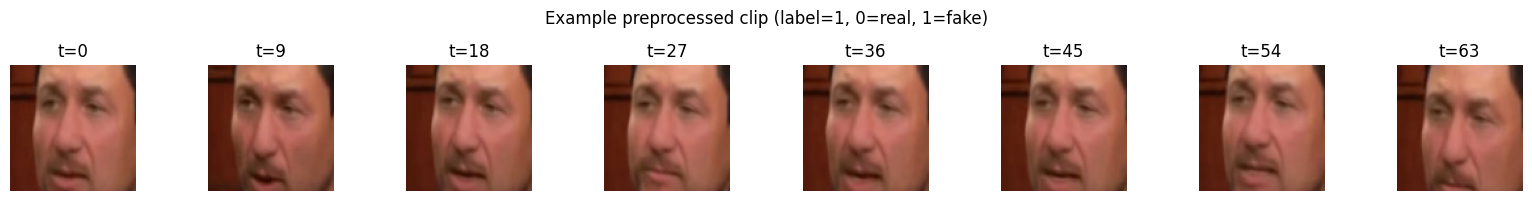

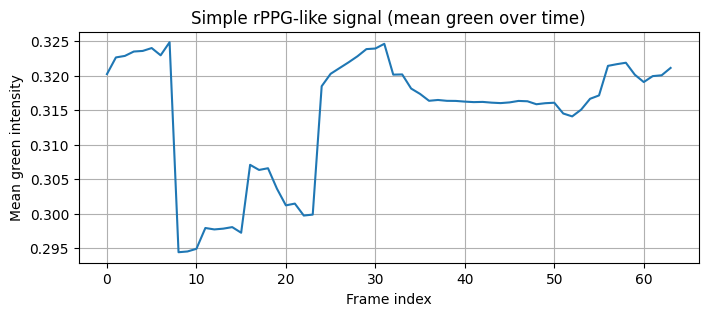

In [26]:
import matplotlib.pyplot as plt

# Take one sample from the validation set
sample_clip, sample_label = val_dataset[1]  # [C, T, H, W], label (0 or 1)

# Convert to numpy for visualization
clip_np = sample_clip.numpy()  # (C, T, H, W)
C, T, H, W = clip_np.shape

# Show a few frames from the clip
num_show = 8
indices = np.linspace(0, T - 1, num_show, dtype=int)

fig, axes = plt.subplots(1, num_show, figsize=(2 * num_show, 2))
for i, idx in enumerate(indices):
    frame = np.transpose(clip_np[:, idx, :, :], (1, 2, 0))  # (H, W, C), RGB in [0,1]
    axes[i].imshow(frame)
    axes[i].axis("off")
    axes[i].set_title(f"t={idx}")
plt.suptitle(f"Example preprocessed clip (label={int(sample_label.item())}, 0=real, 1=fake)")
plt.tight_layout()
plt.show()

# Plot simple "rPPG-like" signal: mean green channel over time
green_channel = clip_np[1]  # C=1 is G (RGB)
rppg_signal = green_channel.mean(axis=(1, 2))  # average over H,W -> [T]

plt.figure(figsize=(8, 3))
plt.plot(rppg_signal)
plt.xlabel("Frame index")
plt.ylabel("Mean green intensity")
plt.title("Simple rPPG-like signal (mean green over time)")
plt.grid(True)
plt.show()

## 1.B Test Evaluation of rPPG Baseline (AUC & Confusion Matrix)

After training the DeepFakesON-Phys-style rPPG baseline, we evaluate it on the **official Celeb-DF (v2) test set**.

We:
1. Runs the trained model on `test_loader`.
2. Computes:
   - Test loss (BCE)
   - Test accuracy
   - ROC AUC
3. Plots:
   - A 2x2 confusion matrix (Real vs Fake).
   - ROC curve

### CELL B2: Evaluate on test set (loss, acc, AUC)

In [27]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.eval()

all_labels = []
all_probs = []
all_preds = []

test_total_loss = 0.0
test_total_samples = 0

with torch.no_grad():
    for clips, labels in tqdm(test_loader, desc="Testing", leave=False):
        clips = clips.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        logits = model(clips)
        loss = criterion(logits, labels)

        probs = torch.sigmoid(logits)        # [B]
        preds = (probs > 0.5).float()        # [B]

        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

        batch_size = labels.size(0)
        test_total_loss += loss.item() * batch_size
        test_total_samples += batch_size

test_loss = test_total_loss / max(1, test_total_samples)

all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)

test_acc = (all_preds == all_labels).mean()

try:
    test_auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    # Happens if only one class present in labels
    test_auc = float("nan")

print(f"Test loss: {test_loss:.4f}")
print(f"Test acc : {test_acc:.4f}")
print(f"Test AUC : {test_auc:.4f}")

Test loss: 0.4777
Test acc : 0.6834
Test AUC : 0.7029


### CELL B3: Visualization – confusion matrix & ROC curve

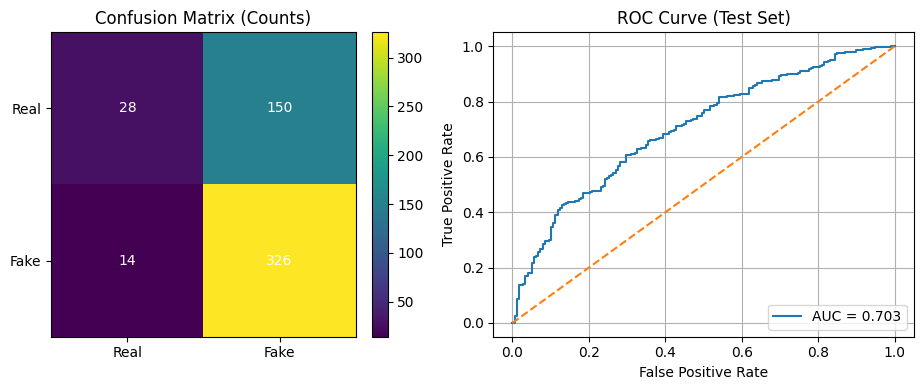

In [28]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Confusion matrix
im0 = ax[0].imshow(cm, interpolation="nearest")
ax[0].set_title("Confusion Matrix (Counts)")
ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(["Real", "Fake"])
ax[0].set_yticklabels(["Real", "Fake"])
for i in range(2):
    for j in range(2):
        ax[0].text(j, i, cm[i, j], ha="center", va="center", color="w")
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# ROC curve
try:
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    ax[1].plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
    ax[1].plot([0, 1], [0, 1], linestyle="--")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve (Test Set)")
    ax[1].legend(loc="lower right")
    ax[1].grid(True)
except ValueError:
    ax[1].text(0.5, 0.5, "ROC not available (single class)", ha="center", va="center")
    ax[1].axis("off")

plt.tight_layout()
plt.show()